# Define model validation metrics

In [1]:
import os
import h5py
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from toolz import valmap, curry
from tqdm.auto import tqdm
from aging.size_norm.lightning import predict

# below is necessary for now, might not need in future iterations
from aging.size_norm.data import clean, Session

from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
)
from aging.plotting import format_plots, PlotConfig, save_factory
from sklearn.metrics import confusion_matrix

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

In [3]:
validation_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/size_network/male_ontogeny_pose_balanced_validation_sample_dataframe.parquet')

In [4]:
validation_df.head()

,labels,file,age,index
12,9,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,12
266,23,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,266
390,7,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,390
470,15,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,470
525,5,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,525


In [5]:
mask = validation_df['age'].str.contains('22mo') | validation_df['age'].str.contains('9mo')

In [6]:
validation_df = validation_df[~mask]

In [7]:
@curry
def has_key(key, path):
    try:
        with h5py.File(path, 'r') as h5f:
            return key in h5f
    except Exception:
        return False

In [8]:
size_key = 'win_size_norm_frames_v4'

In [9]:
# folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males')
# files = sorted(filter(has_key(size_key), folder.glob('*.h5')))

In [10]:
data = {}
preds = {}
# for file in files:
#     with h5py.File(file, 'r') as h5f:
#         print(h5f['metadata/acquisition/SessionName'][()])
for (age, file), _df in tqdm(validation_df.groupby(['age', 'file'])):
    try:
        with h5py.File(file, 'r') as h5f:
            data[(age, file)] = h5f['frames'][_df['index'].to_numpy()]
            preds[(age, file)] = h5f[size_key][_df['index'].to_numpy()]
    except (KeyError, BlockingIOError):
        continue

  0%|          | 0/168 [00:00<?, ?it/s]

## Mouse age classification

Classify age before and after applying model.
Start with logistic regression or random forest classifier.

In [11]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LogisticRegression(max_iter=200)
)

In [12]:
train_data = []
ages = []

for k, v in data.items():
    ages.extend([k[0]] * len(v))
    train_data.append(data[k])
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

In [13]:
unique = np.unique(ages)
unique

array(['12months_28042021', '18months_29042021', '3months_19042021',
       '3wks_02112021', '5wks_02112021', '6months_20042021',
       '7wks_18112021', '9wks_1811_2021'], dtype='<U17')

In [14]:
out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    # cv=StratifiedKFold(5),
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0),
)
out

array([0.466     , 0.48216667, 0.48766667, 0.48433333, 0.46633333,
       0.473     , 0.47766667, 0.47816667, 0.484     , 0.47316667,
       0.47633333, 0.482     , 0.47866667, 0.46966667, 0.48083333,
       0.47966667, 0.46983333, 0.48      , 0.48016667, 0.4795    ])

In [15]:
def age_map(age):
    if '12mo' in age:
        return 12 * 4
    if '18mo' in age:
        return 18 * 4
    if '6mo' in age:
        return 6 * 4
    if '3mo' in age:
        return 3 * 4
    if '3w' in age:
        return 3
    if '5w' in age:
        return 5
    if '7w' in age:
        return 7
    if '9w' in age:
        return 9

In [21]:
lr_preds = cross_val_predict(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(5)
)

[Text(0.5, -22.833333333333336, 'Predicted age (weeks)'),
 Text(-13.583333333333334, 0.5, 'True age (weeks)')]

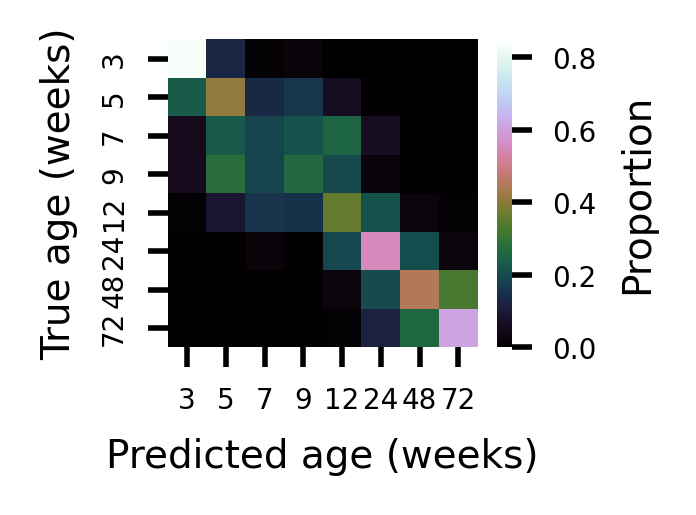

In [24]:
proc_ages = np.array(list(map(age_map, unique)))
sort_labels = np.argsort(proc_ages)
cm = confusion_matrix(ages, lr_preds, labels=unique[sort_labels])

col = proc_ages[sort_labels]
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

fig = plt.figure(figsize=(1.25, 1))
ax = sns.heatmap(cm_df, annot=False, cmap='cubehelix', cbar_kws=dict(label='Proportion'), vmax=0.85, vmin=0)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
# saver(fig, 'raw-pose-age-classification-confusion-mtx');

In [25]:
chance = 1 / len(np.unique(ages))
chance

0.125

In [26]:
train_data = []
ages = []

for k, v in preds.items():
    ages.extend([k[0]] * len(v))
    train_data.append(preds[k])
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

In [27]:
preds_out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    # cv=StratifiedKFold(5),
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0),
)
preds_out

array([0.19616667, 0.205     , 0.20166667, 0.21316667, 0.20883333,
       0.20383333, 0.20583333, 0.20583333, 0.21016667, 0.2045    ,
       0.20466667, 0.2045    , 0.20966667, 0.20033333, 0.21166667,
       0.20316667, 0.20466667, 0.20833333, 0.21283333, 0.20483333])

In [28]:
lr_preds = cross_val_predict(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(5)
)

In [29]:
unique = np.unique(ages)
unique

array(['12months_28042021', '18months_29042021', '3months_19042021',
       '3wks_02112021', '5wks_02112021', '6months_20042021',
       '7wks_18112021', '9wks_1811_2021'], dtype='<U17')

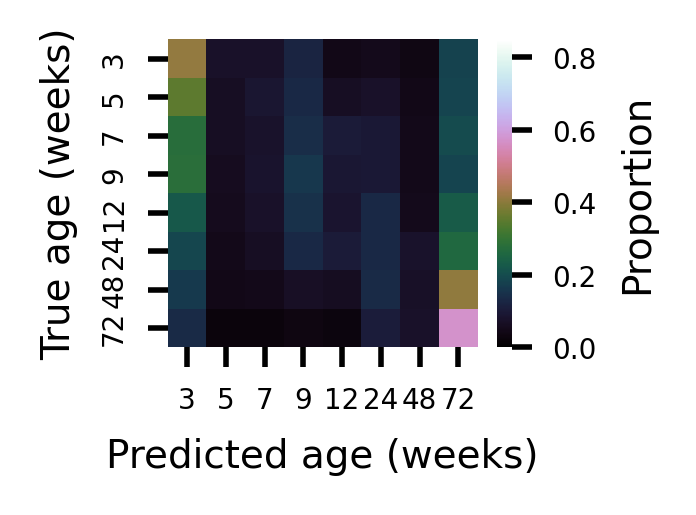

In [30]:
proc_ages = np.array(list(map(age_map, unique)))
sort_labels = np.argsort(proc_ages)
cm = confusion_matrix(ages, lr_preds, labels=unique[sort_labels])

col = proc_ages[sort_labels]
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

fig = plt.figure(figsize=(1.25, 1))
ax = sns.heatmap(cm_df, annot=False, cmap='cubehelix', cbar_kws=dict(label='Proportion'), vmax=0.85, vmin=0)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)');
# saver(fig, 'transformed-pose-age-classification-confusion-mtx');

In [31]:
outcomes = dict(
    Raw=out,
    Transformed=preds_out,
)

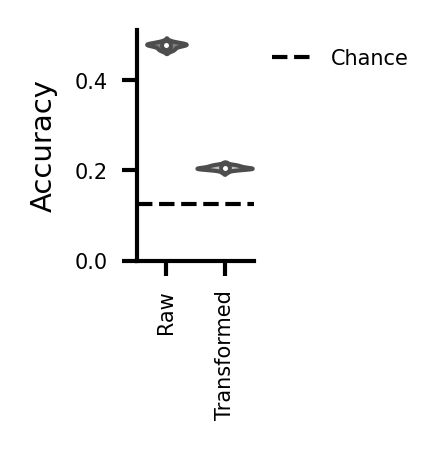

In [32]:
fig = plt.figure(figsize=(0.5, 1))
fig.dpi = 150
ax = sns.violinplot(
    data=pd.DataFrame(outcomes),
    palette=["gray", "silver"],
    linewidth=1,
    saturation=1,
    width=0.95,
)
plt.axhline(chance, color="k", ls="--", label="Chance")
ax.set(ylim=(0, None), ylabel="Accuracy")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
sns.despine()
# saver(fig, "age-decoder-from-pose");

## Preserved pose dynamics

In [ ]:
from aging.behavior.scalars import compute_scalars

In [15]:
def zscore(data):
    return (data - data.mean()) / data.std()

In [6]:
# folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/all_data_pca/Ontogeny_males')
# files = sorted(filter(has_key(size_key), folder.glob('*.h5')))

In [7]:
width_cols = ["width_mm", "recon_width"]
length_cols = ["length_mm", "recon_length"]
height_cols = ["height_ave_mm", "recon_height"]

age_map = {
    "12months": 12 * 4,
    "18months": 18 * 4,
    "3wks": 3,
    "5wks": 5,
    "9wks": 9,
    "7wks": 7,
    "22months": 22 * 4,
    "3months": 3 * 4,
    "6months": 6 * 4,
    "9months": 9 * 4,
}

In [8]:
preserve_df = []
for age, age_df in syll_df.groupby('age'):
    for uuid, uuid_df in age_df.groupby('uuid'):
        smooth_cols = zscore(uuid_df[width_cols + length_cols + height_cols].rolling(5, center=True).mean())
        corrs = np.diag(smooth_cols.corr(), 1)[::2]
        preserve_df.append(dict(
            age=age_map[age],
            uuid=uuid,
            avg_corr=np.mean(corrs),
            **dict(zip(('width', 'length', 'height'), corrs)),
        ))
preserve_df = pd.DataFrame(preserve_df)

In [9]:
preserve_df

,age,uuid,avg_corr,width,length,height
0,48,14d5ccc2-3375-4ba9-b874-5fccde870982,0.838963,0.713328,0.862055,0.941506
1,48,1900e596-c4a5-44ff-ba88-ce3a19b030cd,0.809146,0.637309,0.895541,0.894589
2,48,1a3792eb-abcd-4886-add4-9c6535c843a7,0.820860,0.705501,0.857671,0.899408
3,48,3abf3f43-233d-4370-8110-2b81873de5a7,0.802834,0.668030,0.875626,0.864847
4,48,4223f9ff-a26b-4605-869e-2ee7134f0d22,0.843447,0.707353,0.903244,0.919744
...,...,...,...,...,...,...
208,9,e1862cc7-e23c-4a8b-b134-66b7abee3c1a,0.899287,0.838621,0.909251,0.949988
209,9,e91beae5-468b-4c0b-940d-7663a02a68d0,0.808488,0.723164,0.806166,0.896134
210,9,ec7d35f8-4796-42ee-aa72-c381b95263b4,0.847176,0.740838,0.887215,0.913476
211,9,eca0cb8f-cae1-4a12-9de8-48e14723c7e8,0.905610,0.840387,0.913277,0.963165


In [10]:
best_examples = preserve_df.groupby('age').apply(lambda x: x.loc[x['avg_corr'].idxmax()]).reset_index(drop=True)

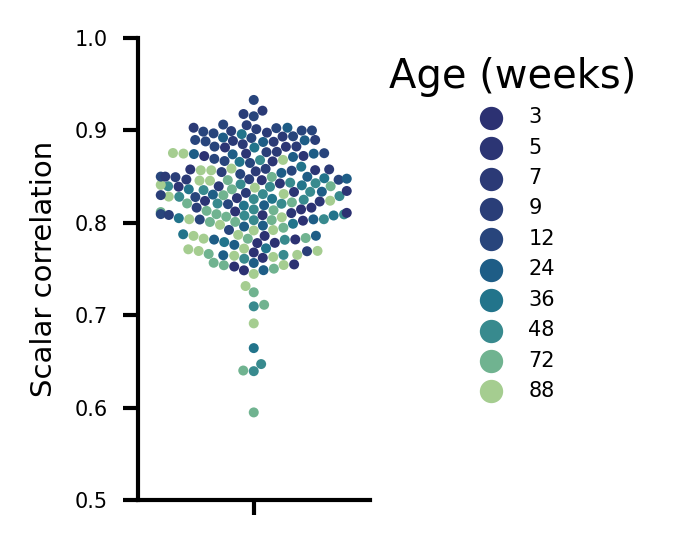

In [23]:
fig = plt.figure(figsize=(1, 2), dpi=150)
ax = sns.swarmplot(
    data=preserve_df,
    y="avg_corr",
    hue="age",
    palette="crest_r",
    size=2.4,
    legend='full',
    norm="log",
    # saturation=1,
)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left', title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel='Scalar correlation')
sns.despine()
# saver(fig, 'correlation-vs-age-swarmplot');

In [132]:
best_examples

,age,uuid,avg_corr,width,length,height
0,3,509f6963-4a1c-43af-9ba4-909c7304cc39,0.872222,0.808744,0.890505,0.917416
1,5,9971bd0c-b48e-41b0-9611-fffc2caede9c,0.882264,0.819882,0.880835,0.946075
2,7,177de7e9-4af1-4fc3-bab1-abe4eb682aa3,0.921323,0.867671,0.916324,0.979972
3,9,2e94b0eb-59fd-41b4-9af0-74f665e93c46,0.917740,0.859790,0.928300,0.965129
4,12,4fc1b9c5-5524-49c3-86b3-b3f8cb1d5a1f,0.932964,0.883347,0.934722,0.980822
5,24,08561952-5528-421c-bb1a-3f8ed3ec9790,0.902889,0.833268,0.908564,0.966835
6,36,e22cc30f-d65a-4d23-9581-18b821030eae,0.895958,0.835801,0.923318,0.928753
7,48,d734c8b9-2ab6-464d-95cf-3dbddcc70880,0.867846,0.809035,0.898670,0.895832
8,72,f436246c-372b-4ce9-9e82-7ba5cefc391c,0.849624,0.722631,0.889674,0.936567
9,88,d7931c99-dd98-4300-8729-08b3be5ad555,0.875534,0.761466,0.907401,0.957736


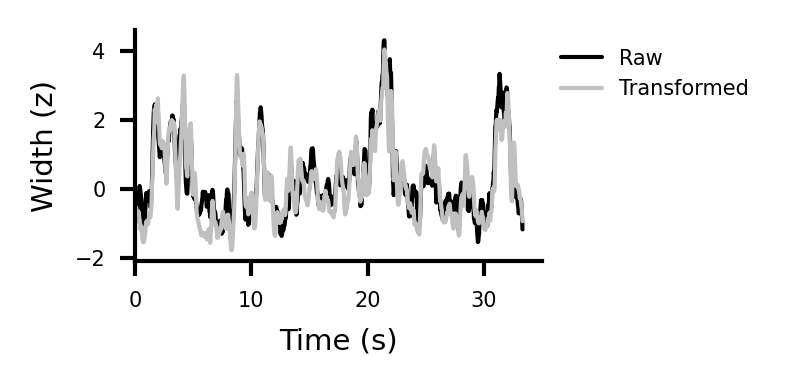

In [133]:
example = syll_df[syll_df['uuid'] == best_examples.query('age == 3')['uuid'].iloc[0]]
smooth_cols = zscore(example[width_cols + length_cols + height_cols].rolling(5, center=True).mean())

# 3wk width
plt_sample = smooth_cols.iloc[3500:4500]

fig = plt.figure(figsize=(1.75, 1), dpi=150)
ax = fig.gca()
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[0]], label='Raw', color='k')
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[1]], label='Transformed', color='silver')
ax.set(ylabel='Width (z)', xlabel='Time (s)', xlim=(0, None))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
sns.despine()
saver(fig, '3wk-width-timeseries');

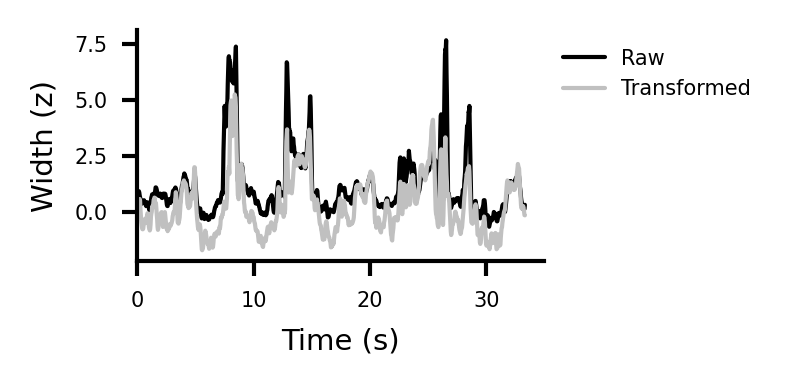

In [134]:
example = syll_df[syll_df['uuid'] == best_examples.query('age == 72')['uuid'].iloc[0]].reset_index(drop=True)
smooth_cols = zscore(example[width_cols + length_cols + height_cols].rolling(5, center=True).mean())

# 18 month width
plt_sample = smooth_cols.iloc[2000:3000]

fig = plt.figure(figsize=(1.75, 1), dpi=150)
ax = fig.gca()
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[0]], label='Raw', color='k')
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[1]], label='Transformed', color='silver')
ax.set(ylabel='Width (z)', xlabel='Time (s)', xlim=(0, None))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
sns.despine()
saver(fig, '18mo-width-timeseries');